<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/salamhha/handson-ml3/blob/main/practice/Chapter08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [ ]:
# PCA
import numpy as np

# Make small 3D dataset
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [ ]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]
W2 = Vt[:2].T
X2D = X_centered @ W2

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [ ]:
# Choosing the right number of dimensions
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # d equals 154

In [ ]:
# Indicating ratio of variance we want to preserve
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

np.int64(154)

In [ ]:
# Using dimensionality reduction as a preprocessing step in
# training a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10,80),
    "randomforestclassifier__n_estimators": np.arange(50,500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [ ]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(304), 'pca__n_components': np.int64(62)}


In [ ]:
# Reversing compression
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
# Randomized PCA
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [ ]:
# Incremental PCA
from sklearn.decomposition import IncrementalPCA

n_batches=100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [ ]:
# Using memory-mapped file to similar effect
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write',
                   shape = X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

In [ ]:
X_mmap = np.memmap(filename, dtype='float32',
                   mode='readonly').reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

In [ ]:
# Random Projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps = ε)
d

np.int64(7300)

In [ ]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d) # std dev = square root of variance
X = np.random.randn(m, n) # generate fake dataset
X_reduced = X @ P.T

In [ ]:
# Same example with Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection
gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [ ]:
from sklearn.random_projection import SparseRandomProjection
sparse_rnd_proj = SparseRandomProjection(eps=ε, random_state=42)
X_reduced = sparse_rnd_proj.fit_transform(X)

In [ ]:
# Performing inverse transform
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [ ]:
# Locally Linear Embedding
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

In [1]:
# Exercise 9
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X_train = mnist.data[:60_000]
y_train = mnist.target[:60_000]
X_test = mnist.data[60_000:]
y_test = mnist.target[60_000:]

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
%time rf_clf.fit(X_train, y_train)

CPU times: user 54.3 s, sys: 106 ms, total: 54.4 s
Wall time: 54.7 s


RandomForestClassifier(random_state=42)

In [16]:
%time rf_clf.score(X_test, y_test)

CPU times: user 396 ms, sys: 11 ms, total: 407 ms
Wall time: 406 ms


0.9705

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
rf_pca_clf = make_pipeline(PCA(random_state=42, n_components=0.95),
                    RandomForestClassifier(random_state=42))
%time rf_pca_clf.fit(X_train, y_train)

CPU times: user 3min 1s, sys: 451 ms, total: 3min 2s
Wall time: 3min 2s


Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [18]:
%time rf_pca_clf.score(X_test, y_test)

CPU times: user 814 ms, sys: 45.9 ms, total: 860 ms
Wall time: 645 ms


0.9488

In [19]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: user 3min 3s, sys: 228 ms, total: 3min 3s
Wall time: 3min 4s


SGDClassifier(random_state=42)

In [20]:
%time sgd_clf.score(X_test, y_test)

CPU times: user 82.7 ms, sys: 11.9 ms, total: 94.6 ms
Wall time: 114 ms


0.874

In [21]:
sgd_pca_clf = make_pipeline(PCA(random_state=42, n_components=0.95),
                    SGDClassifier(random_state=42))
%time sgd_pca_clf.fit(X_train, y_train)

CPU times: user 45.9 s, sys: 139 ms, total: 46.1 s
Wall time: 45.1 s


Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                ('sgdclassifier', SGDClassifier(random_state=42))])

In [23]:
%time sgd_pca_clf.score(X_test, y_test)

CPU times: user 231 ms, sys: 20.9 ms, total: 252 ms
Wall time: 533 ms


0.8959

In [30]:
# Exercise 10
from sklearn.manifold import TSNE
X_train, y_train = mnist.data[:5_000], mnist.target[:5_000]
tsne = TSNE(n_components=2,random_state=42)
X_reduced = tsne.fit_transform(X_train)

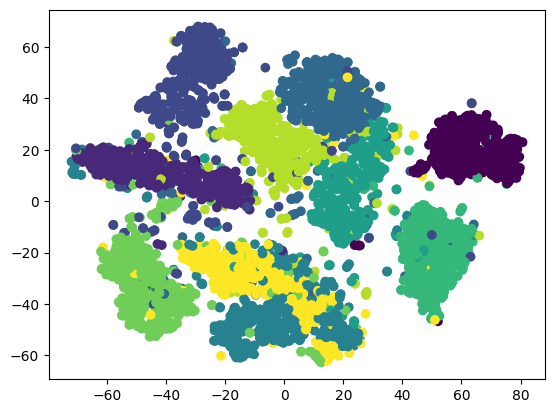

In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_train.astype(np.int8))